In [1]:
# Loading required libraries and initializing
from langdetect import DetectorFactory
from pandas import Series, DataFrame
from string import punctuation
from nltk.tokenize import word_tokenize

In [2]:
# Loading custom defined functions
from tokenization import tokenize_sentence_nltk, tokenize_treetagger
from util import read_file, flatten_list_of_list, read_folder#, clean_sentences
from util import pick_first_language, is_english_wp_p, spell_correct_tokens
from util import detect_language, postprocess_sentences, get_redundaunt_info
from util import filter_data, filter_senders, filter_recipients, search_patterns
from pos_tagging import run_treetagger_pos_tag_text
from modeling import apply_bigram_trigram_model, run_aff_prop_with_distances, run_kmeans
from nltk.stem import WordNetLemmatizer
from modeling import run_word2vec_model, run_lda_topic_model, build_logistic_regression
from visualizing import visualize_word2vec_model
from util import get_semantic_similarity, get_character_similarity
from lemmatization import lemmatize_treetagger
from util import run_treetagger, join_tokens, parse_date, is_spelled_correctly
from json import load

In [3]:
DetectorFactory.seed = 0

in_file = load(open("in_file.cfg", 'r'))
patterns_file = in_file["patterns_file"]
file_folder = in_file["file_folder"]
label = in_file["label"]
column = in_file["column"]
in_type = in_file["in_type"]
in_file = in_file["in_file"]
if file_folder == "file":
    strings = read_file(in_file, in_type = in_type)
    if in_type == "text":
        strings = tokenize_sentence_nltk(strings)
        strings = DataFrame(strings)[0]
    elif in_type == "html_chat":
        timestamp = strings[2]
        meta_data = strings[1]
        strings = strings[0]
        strings[label] = meta_data["Comment"]
        labels = strings[label]
        strings = strings[col]
    else:
        if label in strings.columns:
            labels = strings[label]
        strings = strings[col]
else:
    strings = read_folder(in_file, in_type = in_type)

patterns = Series([".*" + x + ".*" for x in open(patterns_file, 'r').readlines()])

# For html_chat:
# strings -> DataFrame; meta_data -> Series; timestamp -> Series

# For csv, html_email, enron_email:
# strings -> DataFrame

# For folder:
# Sames as file

# html_email and enron_email will have columns 'conversation' (string) and 'meta_data' (dictionary)

# html_chat will have columns "itemId", "messageType", "messageDirection", "case", "captureDate", "policyAction", "statusMarkDate", "status", "status_reviewer", "commentDate", "comment", "comment_reviewer", "participants", "timestamp", "language", "sender", "recipients", "subject", "conversation", "num_of_conversation_turns" and "messages"

In [4]:
if in_type == "html_email" or in_type == "enron_email":
    conv = strings["conversation"].apply(tokenize_sentence_nltk)
    strings = strings["meta_data"].apply(Series)
    strings["conversation"] = conv
    try:
        strings["Sent"] = strings["Sent"].apply(parse_date)
    except:
        pass
    try:
        # 1900/01/01 00:00:00 is equivalent to NULL
        strings["Date"] = strings["Date"].apply(parse_date) # This is time consuming function, but it is robust
    except:
        pass

# For html_email, enron_email ->
# 1) tokenize the strings to create list of sentences
# 2) convert meta data from dictionary to columns
# 3) parse "Sent" and "Date" columns from string to datetime.datetime (1900-01-01 00:00:00 is equivalent to NULL)

In [5]:
strings.head()

,Cc,ContentTransferEncoding,ContentType,Date,From,MessageID,MimeVersion,Sent,Subject,To,XFileName,XFolder,XFrom,XOrigin,XTo,Xbcc,Xcc,conversation
0,NaN,7bit,text/plain; charset=us-ascii,NaT,heather.dunton@enron.com,<16159836.1075855377439.JavaMail.evans@thyme>,1.0,1900-01-01 00:00:00,RE: West Position,k..allen@enron.com,pallen (Non-Privileged).pst,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox","Dunton, Heather </O=ENRON/OU=NA/CN=RECIPIENTS/...",Allen-P,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",,,[Please let me know if you still need Curve Sh...
1,NaN,NaN,NaN,1900-01-01,"Allen, Phillip K",NaN,NaN,2001-12-07 05:14:00,RE: West Position,"Dunton, Heather",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Heather, ., Did you attach the file to this e..."
2,NaN,NaN,NaN,1900-01-01,"Dunton, Heather",NaN,NaN,2001-12-05 13:43:00,FW: West Position,"Allen, Phillip K.; Belden, Tim",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Attached is the Delta position for 1/16, 1/30..."
3,NaN,NaN,NaN,1900-01-01,"Allen, Phillip K",NaN,NaN,2001-12-05 06:41:00,RE: West Position,"Dunton, Heather",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Heather, ., This is exactly what we need ., W..."
4,"Driscoll, Michael M",NaN,NaN,1900-01-01,"Dunton, Heather",NaN,NaN,2001-12-04 15:12:00,West Position,"Belden, Tim; Allen, Phillip K",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Attached is the Delta position for 1/18, 1/31..."


In [6]:
if in_type == "html_chat":
    redundant = get_redundaunt_info(strings)
    total_redundant = redundant.sum()
    from re import findall
    unnecessary1 = strings['sender'].apply(lambda x: len(findall("^gg.*", x.lower())) > 0)
    unnecessary2 = strings['participants'].apply(lambda x: sum([len(findall("^gg.*|\;gg.*", y)) for y in x]) > 0)
    unnecessary = unnecessary1 | unnecessary2
    total_unnecessary = unnecessary.sum()
    # Deduplication
    strings = filter_senders(strings)
    strings.head()
    strings = filter_recipients(strings)
    strings.head()
    strings = filter_data(strings)
    strings.head()
    strings1 = strings.drop(['messages'], axis = 1).reset_index(drop = True)
    strings = strings['messages'].reset_index(drop = True)
    strings = strings.apply(lambda x: " ".join(x))

# For html_chat ->
# Remove unnecessary chat history: gg.* is the pattern for unwanted senders/participants
# Remove duplicate chats
# strings1 is a DataFrame with all columns except 'messages'
# strings is a Series (string) which is used for downstream NLP

In [7]:
strings.head()

,Cc,ContentTransferEncoding,ContentType,Date,From,MessageID,MimeVersion,Sent,Subject,To,XFileName,XFolder,XFrom,XOrigin,XTo,Xbcc,Xcc,conversation
0,NaN,7bit,text/plain; charset=us-ascii,NaT,heather.dunton@enron.com,<16159836.1075855377439.JavaMail.evans@thyme>,1.0,1900-01-01 00:00:00,RE: West Position,k..allen@enron.com,pallen (Non-Privileged).pst,"Phillip_Allen_Jan2002_1\Allen, Phillip K.\Inbox","Dunton, Heather </O=ENRON/OU=NA/CN=RECIPIENTS/...",Allen-P,"Allen, Phillip K. </O=ENRON/OU=NA/CN=RECIPIENT...",,,[Please let me know if you still need Curve Sh...
1,NaN,NaN,NaN,1900-01-01,"Allen, Phillip K",NaN,NaN,2001-12-07 05:14:00,RE: West Position,"Dunton, Heather",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Heather, ., Did you attach the file to this e..."
2,NaN,NaN,NaN,1900-01-01,"Dunton, Heather",NaN,NaN,2001-12-05 13:43:00,FW: West Position,"Allen, Phillip K.; Belden, Tim",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Attached is the Delta position for 1/16, 1/30..."
3,NaN,NaN,NaN,1900-01-01,"Allen, Phillip K",NaN,NaN,2001-12-05 06:41:00,RE: West Position,"Dunton, Heather",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Heather, ., This is exactly what we need ., W..."
4,"Driscoll, Michael M",NaN,NaN,1900-01-01,"Dunton, Heather",NaN,NaN,2001-12-04 15:12:00,West Position,"Belden, Tim; Allen, Phillip K",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"[Attached is the Delta position for 1/18, 1/31..."


In [8]:
try:
    strings = strings["conversation"]
except:
    pass

strings = strings.apply(postprocess_sentences)

# For html_email and enron_email -> pick conversation column for downstream NLP

In [9]:
from re import sub
strings = strings.apply(lambda string: sub(pattern = "[\ ]{2,}", repl = " ", string = string))
strings = strings.apply(lambda string: sub(pattern = "[\ ]{1,}[\.]", repl = " .", string = string))
strings = strings.apply(lambda string: sub(pattern = "[\ \.]*[\.]", repl = " .", string = string))

In [10]:
strings.head()

0    Please let me know if you still need Curve Shi...
1    Heather, . Did you attach the file to this ema...
2    Attached is the Delta position for 1/16, 1/30,...
3    Heather, . This is exactly what we need . Woul...
4    Attached is the Delta position for 1/18, 1/31,...
Name: conversation, dtype: object

In [11]:
# Identifying keyword hits
hits = strings.apply(lambda x: search_patterns(x, patterns))
hits['any'] = hits.apply(sum, axis = 0)
hit_strings = strings[hits['any'] > 0]

# Pattern matching -> store in 'hits' if any of the string patterns match

In [12]:
# Language filter for downstream NLP
languages = strings.apply(detect_language)

# Picking the language with highest probability
first_language = languages.apply(pick_first_language)

# Keeping only English text
english_only = first_language.apply(is_english_wp_p)
strings = strings[english_only]
# labels = labels[english_only].tolist()

# Retain only English text in strings
# labels is for supervised learning (future use)

In [13]:
# Processing English sentences:
# 1) Tokenization
sentences = strings.apply(tokenize_treetagger)
lengths = sentences.apply(len)

# new_labels = []
# for i in range(len(lengths)):
#     for j in range(lengths[i]):
#         new_labels.append(labels[i])
# new_labels = Series(new_labels)
# sentences1 = flatten_list_of_list(sentences)

# sentences -> list of (list for tokens) -> outer list: one list per sentence

In [14]:
sentences = sentences[lengths > 0]

# lengths -> used to remove sentences that are not tokenized

In [18]:
# 2) Run part-of-speech tagging on clean sentences
sentences1 = sentences.apply(lambda x: join_tokens(x))
pos = sentences1.apply(run_treetagger_pos_tag_text).apply(DataFrame)

# sentences1 -> tokens joined back into single string with '. ' separating sentences
# pos -> DataFrame with part-of-speech of sentences1

In [19]:
# 3) Spell correct - currently correct only disjoint words
lengths = pos.apply(len)
inc_sentences = sentences1[lengths == 0]
# inc_labels = new_labels[lengths == 0]
pos = pos[lengths > 0]
# labels = new_labels[lengths > 0]
sentence_tokens = pos.apply(spell_correct_tokens)

# lengths -> used to remove sentences for which pos is not tagged
# sentences_tokens -> combine words in pos if: a) word and adjacent word are incorrectly spelled, b) combination of words is correctly spelled

In [20]:
# 4) Combine tokens to form bigrams and trigrams
# sentence_tokens = sentences.apply(tokenize_treetagger)
trigrams = apply_bigram_trigram_model(sentence_tokens)

# trigrams -> Series of lists: unigrams, bigram phrases (word1_word2) and trigram phrases (word1_word2_word3)

C:\Users\naveen.nathan\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:862: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


In [21]:
# 5) Form the sentence back from tokens
sentences1 = ["".join([" "+lemmatize_treetagger(run_treetagger(i.lower())) if not i.startswith("'") and i not in punctuation
                       else i for i in tokens]).strip() for tokens in trigrams]
# labels = labels.tolist() + inc_labels.tolist()

# Join the sentences back
# sentences1 -> list of strings

In [22]:
# 6) Write clean text to text file - one line per sentence
out_file = open("sample.txt", "w")
for sent in sentences1:
    out_file.write(sent.lower().replace("( ", "(").replace(" )", ")").replace("replaced-dns ", "").replace("replaced-dns", "")+"\n")

out_file.close()

# sentences1 written to text file "sample.txt" for word2vec and LDA models

In [23]:
# 7) Run word2vec model and store word representations
model = run_word2vec_model("sample.txt")
model.wv.save_word2vec_format("big.w2v")

# Build word2vec model on "sample.txt" and save model to "big.w2v"

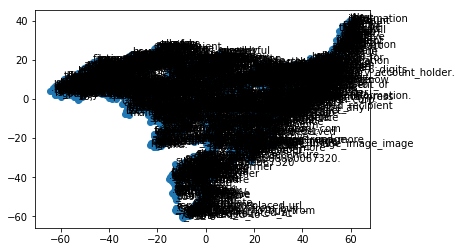

In [24]:
# 8) Visualizing the word2vec model
visualize_word2vec_model(model)

# Visualize word2vec model in 2d using t-SNE

In [25]:
# 9) Setting up the data for building logistic regression model
#df = zeros((len(sentences1), 100))
#for i, words in enumerate(trigrams):
#    for word in words:
#        try:
#            df[i] = df[i] + model[word]
#        except:
#            continue

#while(i<len(sentences1)):
#    i += 1
#
#df = DataFrame(df)
#df[label] = labels

# This is for building supervised learning model using sentence embeddings as predictors

In [26]:
# 10) Building and saving the logistic regression model with L1 penalty
#lr_model = build_logistic_regression(df, label)
#dump(lr_model, open("logistic_model.pkl", 'wb'))

# Build and dump the model

In [27]:
# 11) Topic modeling (Optional)
#lda_model = run_lda_topic_model(text_file = "sample_cleaned.txt")
# Sample topic modeling output - Topic 1
#lda_model.print_topic(1)

In [28]:
sim1 = get_semantic_similarity(model)

# Get m x m matrix of semantic (cosine) similarity between words in vocabulary

In [29]:
vocab = list(model.wv.vocab)

# Get all m words in vocabulary

In [30]:
# ratio = get_character_similarity(vocab, 'ratio')

# Compute m x m character-based similarity metric between words in vocabulary

In [31]:
# partial_ratio = get_character_similarity(vocab, "partial_ratio")

In [32]:
# token_sort_ratio = get_character_similarity(vocab, "token_sort_ratio")

In [33]:
# token_set_ratio = get_character_similarity(vocab, "token_set_ratio")

In [34]:
# sim1 = sim1[ratio.columns]
# sim1 = sim1.loc[ratio.columns]

# sim1 is m x m matrix

In [35]:
# semantic_weight = 0.5
# ratio_weight = 0.4
# partial_ratio_weight = 0.4
# token_sort_ratio_weight = 0.1
# sim = semantic_weight*sim1 + (ratio_weight*ratio + partial_ratio_weight*partial_ratio + token_sort_ratio_weight*token_sort_ratio + (1-ratio_weight-partial_ratio_weight-token_sort_ratio_weight)*token_set_ratio)*(1-semantic_weight)
# dist = 1 - sim

# Currently heuristic weights are assigned for different similarities
# dist is m x m matrix

In [36]:
# aff = run_aff_prop_with_distances(dist)

# Run affinity propagation model on computed composite distance matrix and store in aff

In [37]:
# visualize_word2vec_model(model, aff.labels_)

# Visualize word2vec model with labels as per affinity propagation clusters

In [38]:
# columns = sim.columns
# condition = Series(sim.columns).apply(is_spelled_correctly)
# sim = sim.loc[columns[~condition]]
# sim = sim[columns[condition]]

# Identify mis-spelled words and find nearest words; words with '_' are also considered correct (this needs some thought)

In [39]:
# sim.apply(lambda x: x.sort_values().index[0], axis = 1)

In [40]:
df = DataFrame(model.wv[model.wv.vocab])
df.columns = ['c' + str(i) for i in range(df.shape[1])]
km = run_kmeans(model.wv[model.wv.vocab])

# Run kmeans model and store in km object

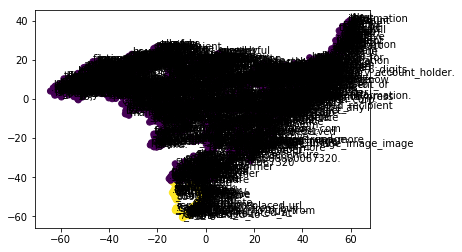

In [41]:
visualize_word2vec_model(model, km.cluster)

# Visualize word2vec with kmeans cluster labels

In [42]:
lda_model, corpus, dictionary = run_lda_topic_model(text_file = "sample.txt")

# Run gensim LDA model on "sample.txt" and return model (lda_model), corpus (corpus) and dictionary (dictionary)

In [43]:
lda_model.print_topics(-1)

# Prints all topics

[(0,
  '0.026*"office" + 0.026*"post" + 0.016*"phillip" + 0.016*"time" + 0.016*"return" + 0.013*"find" + 0.013*"know" + 0.011*"might" + 0.011*"look" + 0.011*"number"'),
 (1,
  '0.003*"ibs" + 0.002*"information" + 0.002*"account" + 0.002*"please" + 0.002*"try" + 0.001*"client" + 0.001*"back" + 0.001*"process" + 0.001*"this_is" + 0.001*"call"'),
 (2,
  '0.004*"2001" + 0.003*"thanks" + 0.002*"request" + 0.002*"information" + 0.002*"brad" + 0.002*"attached_is" + 0.002*"you_have" + 0.002*"jones" + 0.002*"scenario" + 0.002*"script"'),
 (3,
  '0.003*"image" + 0.002*"2001" + 0.001*"book" + 0.001*"2000" + 0.001*"you_save" + 0.001*"buy" + 0.001*"downgraded_to" + 0.001*"04" + 0.001*"upgraded_to" + 0.001*"garden"'),
 (4,
  '0.002*"draw" + 0.002*"2" + 0.001*"cash" + 0.001*"pay" + 0.001*"galaxy" + 0.001*"cost" + 0.001*"total" + 0.001*"one" + 0.001*"1" + 0.001*"see"'),
 (5,
  '0.004*".com" + 0.004*".zdnet" + 0.004*"replaced-url_replaced-url" + 0.004*"slink" + 0.002*"adeskb" + 0.002*"adt1231" + 0.002*

In [44]:
from util import get_word_lda_topics
Series(list(lda_model.id2word.values())).apply(lambda x: get_word_lda_topics(lda_model, x))

# Supposed to get list of all topics for each word in vocab -> not working for some reason (returns None)

0           (please_let_me_know, [(13, 0.0153804036694)])
1       (if_you, [(13, 0.0149459733373), (94, 0.010660...
2                        (still, [(13, 0.0155476286467)])
3       (need, [(13, 0.026688115652), (19, 0.011240266...
4                        (curve, [(13, 0.0269522172638)])
5                        (shift, [(13, 0.0267119905334)])
6       (thanks, [(13, 0.0149507814457), (15, 0.015095...
7       (heather, [(13, 0.0269522172638), (74, 0.01519...
8       (attach, [(15, 0.0150951011823), (74, 0.015193...
9                         (file, [(74, 0.0155181444818)])
10                  (this_email, [(74, 0.0151933594983)])
11                 (attached_is, [(42, 0.0252539403251)])
12                                            (delta, [])
13                                         (position, [])
14      (1, [(70, 0.0129010403322), (83, 0.02085906386...
15                                               (16, [])
16                                               (30, [])
17            

In [45]:
from gensim.models.ldamodel import LdaModel


In [46]:
from visualizing import visualize_lda_topics
visualize_lda_topics(lda_model, corpus, dictionary)

# Visualize LDA model using MDS

PreparedData(topic_coordinates=            Freq  cluster  topics         x         y
topic                                                
8      11.338339        1       1  0.062611  0.037008
81      6.632830        1       2 -0.157722 -0.028206
72      6.095243        1       3 -0.205982 -0.065999
79      5.810744        1       4 -0.252712 -0.012811
22      5.689197        1       5 -0.119627  0.022352
86      3.886639        1       6 -0.026212  0.141233
52      3.801203        1       7 -0.139405  0.352076
59      3.708090        1       8 -0.127634  0.361407
54      3.168917        1       9 -0.156277 -0.011673
63      3.166784        1      10 -0.153002 -0.133219
94      3.050706        1      11 -0.216047 -0.030973
19      2.869332        1      12 -0.183886 -0.041854
65      2.865369        1      13 -0.186095  0.022794
45      2.691646        1      14 -0.136379  0.054661
96      2.633838        1      15 -0.135640 -0.067988
17      2.594925        1      16 -0.065198  0.018429
62      2.232836        1      17 -0.136013 -0.045170
77      1.936027        1      18 -0.084949 -0.107491
7       1.791924        1      19 -0.100833 -0.032615
90      1.725724        1      20 -0.105791 -0.067130
70      1.714856        1      21 -0.088437 -0.039802
0       1.595453        1      22 -0.065411 -0.069903
49      1.576792        1      23 -0.083732  0.123521
91      1.534735        1      24 -0.116451 -0.012541
83      1.358579        1      25 -0.074459 -0.016613
50      1.342904        1      26 -0.103506 -0.079717
21      1.182200        1      27 -0.032032 -0.007519
41      1.114031        1      28 -0.024355 -0.035410
48      1.034457        1      29 -0.048700 -0.081262
57      1.001395        1      30 -0.032115 -0.048910
...          ...      ...     ...       ...       ...
31      0.007884        1      71  0.048640  0.057266
34      0.007884        1      72  0.067613 -0.001023
78      0.007884        1      73  0.041162  0.002043
71      0.007884        1      74  0.057750  0.006522
80      0.007884        1      75  0.041958 -0.014551
69      0.007884        1      76  0.046489 -0.001313
68      0.007884        1      77  0.057033 -0.011362
66      0.007884        1      78  0.065534 -0.005306
82      0.007884        1      79  0.060285 -0.015424
64      0.007884        1      80  0.033274  0.020701
84      0.007884        1      81  0.067811 -0.000303
61      0.007884        1      82  0.059825 -0.002393
85      0.007884        1      83  0.044822 -0.009715
56      0.007884        1      84  0.059737 -0.000868
55      0.007884        1      85  0.064734 -0.001914
87      0.007884        1      86  0.063081 -0.004704
53      0.007884        1      87  0.031782 -0.021179
88      0.007884        1      88  0.033596 -0.015441
51      0.007884        1      89  0.044660  0.101592
98      0.007884        1      90  0.064258 -0.007165
46      0.007884        1      91  0.063931 -0.001296
89      0.007884        1      92  0.067989 -0.001507
44      0.007884        1      93  0.066095  0.007625
43      0.007884        1      94  0.070659  0.000337
39      0.007884        1      95  0.041312 -0.018056
75      0.007884        1      96  0.030083  0.052855
37      0.007884        1      97  0.045231 -0.016585
36      0.007884        1      98  0.070654  0.000500
35      0.007884        1      99  0.047615 -0.007018
99      0.007884        1     100  0.066104 -0.000016

[100 rows x 5 columns], topic_info=      Category       Freq                       Term      Total  loglift  \
term                                                                       
56     Default  72.000000                       2001  72.000000  30.0000   
355    Default  51.000000                      image  51.000000  29.0000   
79     Default  65.000000                       .com  65.000000  28.0000   
44     Default  51.000000  replaced-url_replaced-url  51.000000  27.0000   
269    Default  39.000000                information  39.000000  26.0000   

In [47]:
from sentiment_analysis import tag_sentiment_nltk
from util import get_sentiment_with_highest_score

C:\Users\naveen.nathan\AppData\Local\Continuum\anaconda3\lib\site-packages\stanfordcorenlp-3.9.1.1-py3.6.egg\stanfordcorenlp\corenlp.py:245: DeprecationWarning: invalid escape sequence \d
C:\Users\naveen.nathan\AppData\Local\Continuum\anaconda3\lib\site-packages\stanfordcorenlp-3.9.1.1-py3.6.egg\stanfordcorenlp\corenlp.py:245: DeprecationWarning: invalid escape sequence \d


In [48]:
Series(sentences1).apply(tag_sentiment_nltk).apply(get_sentiment_with_highest_score)

# Tag sentiments and return sentiment with highest probability

0     neu
1     neu
2     neu
3     neu
4     neu
5     neu
6     neu
7     neu
8     neu
9     neu
10    neu
11    neu
12    neu
13    neu
14    neu
15    neu
16    neu
17    neu
18    neu
19    neu
20    neu
21    neu
22    neu
23    neu
24    neu
25    neu
26    neu
27    neu
28    neu
29    neu
     ... 
48    neu
49    neu
50    neu
51    neu
52    neu
53    neu
54    neu
55    neu
56    neu
57    neu
58    neu
59    neu
60    neu
61    neu
62    neu
63    neu
64    neu
65    neu
66    neu
67    neu
68    neu
69    neu
70    neu
71    neu
72    neu
73    neu
74    neu
75    neu
76    neu
77    neu
Length: 78, dtype: object

In [49]:
from sentiment_analysis import tag_sentiment_stanfordcorenlp
tag_sentiment_stanfordcorenlp(sentences1[0])

['Negative', 'Positive', 'Neutral']

In [60]:
Series(sentences1).apply(tag_sentiment_stanfordcorenlp)

0                         [Negative, Positive, Neutral]
1                           [Neutral, Neutral, Neutral]
2                                            [Negative]
3     [Neutral, Neutral, Neutral, Negative, Neutral,...
4      [Negative, Negative, Neutral, Negative, Neutral]
5     [Positive, Neutral, Positive, Neutral, Neutral...
6     [Negative, Negative, Positive, Neutral, Negati...
7     [Negative, Neutral, Neutral, Neutral, Negative...
8     [Positive, Neutral, Neutral, Negative, Positiv...
9     [Negative, Negative, Neutral, Negative, Neutra...
10    [Positive, Neutral, Positive, Negative, Neutra...
11    [Negative, Negative, Positive, Neutral, Negati...
12    [Negative, Negative, Positive, Neutral, Negati...
13    [Negative, Negative, Neutral, Negative, Neutra...
14                        [Negative, Positive, Neutral]
15    [Negative, Positive, Neutral, Negative, Neutra...
16    [Negative, Neutral, Neutral, Neutral, Neutral,...
17    [Neutral, Negative, Neutral, Positive, Neu

In [58]:
sentences2 = sentences.apply(lambda x: " ".join(x))
sentences2.apply(tag_sentiment_stanfordcorenlp)

0                         [Positive, Positive, Neutral]
1                           [Neutral, Neutral, Neutral]
2                                            [Negative]
3     [Neutral, Neutral, Neutral, Negative, Positive...
4        [Negative, Neutral, Neutral, Neutral, Neutral]
5     [Neutral, Neutral, Negative, Neutral, Neutral,...
6     [Negative, Negative, Positive, Positive, Negat...
7     [Positive, Neutral, Neutral, Neutral, Negative...
8     [Positive, Negative, Neutral, Negative, Positi...
9     [Negative, Positive, Neutral, Neutral, Negativ...
10    [Neutral, Neutral, Positive, Negative, Neutral...
12    [Negative, Negative, Positive, Positive, Negat...
13    [Negative, Negative, Positive, Positive, Negat...
14    [Negative, Positive, Neutral, Neutral, Negativ...
15                         [Neutral, Positive, Neutral]
16    [Negative, Neutral, Neutral, Positive, Neutral...
17    [Negative, Neutral, Neutral, Neutral, Neutral,...
18    [Neutral, Negative, Neutral, Neutral, Neut